In [1]:
%ls

__init__.py            local_ghz_protocol.py  qlan_example.ipynb
__pycache__/           qlan_app.ipynb         set_linear_graph_5.py
gen_ghz3_example.py    qlan_app.log           topologies/
gen_ghz_example.py     qlan_app.py


In [2]:
import sys
import os

# Adding root project path to sys.path
project_root_path = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(project_root_path)

from typing import List
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from sequence.topology.node import Node
from sequence.kernel.timeline import Timeline
from sequence.components.memory import Memory
from sequence.message import Message
from sequence.utils import log
from sequence.components.optical_channel import ClassicalChannel

from qlan.qlan_orchestrator import QlanOrchestratorNode
from qlan.qlan_client import QlanClientNode
from qlan.graph_gen import qlan_entangle_memory

In [3]:
DESIRED_OUTCOMES = '00'
#DESIRED_OUTCOMES = 'random'

In [4]:
def pair_protocol(orchestrator: QlanOrchestratorNode, clients: list[QlanClientNode]):
    
    p_orch = orchestrator.protocols[0]
    orch_memo_name1 = orchestrator.resource_manager.memory_names[0]
    orch_memo_name2 = orchestrator.resource_manager.memory_names[1]
    protocols_names = []
    clients_names = []
    clients_memory_names = []
    
    for client in clients:
        p_client = client.protocols[0]
        protocols_names.append(p_client)
        clients_names.append(client.name)
        clients_memory_names.append(client.resource_manager.memory_names[0])

        p_client.set_others(p_orch.name, orchestrator.name, [orch_memo_name1, orch_memo_name2])

    p_orch.set_others(protocols_names, clients_names, [orch_memo_name1, orch_memo_name2])

# Function to convert a state vector to a density matrix
def state_vector_to_density_matrix(state_vector: "KetState"):
    state = state_vector.state
    state_vector = np.array(state, dtype=np.complex128)
    density_matrix = np.outer(state_vector, np.conj(state_vector))
    return density_matrix

def plot_density_matrix(density_matrix):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
        
    # Real part
    im1 = ax1.imshow(density_matrix.real, cmap='viridis')
    ax1.set_title('Real Part of Density Matrix')
    ax1.set_xlabel('X')
    ax1.set_ylabel('Y')
    ax1.set_xticks(np.arange(density_matrix.shape[1]))
    ax1.set_yticks(np.arange(density_matrix.shape[0]))
    ax1.set_xticklabels(np.arange(density_matrix.shape[1]), rotation=90)
    ax1.set_yticklabels(np.arange(density_matrix.shape[0]))
    ax1.xaxis.set_major_locator(plt.MaxNLocator(integer=True))
    ax1.yaxis.set_major_locator(plt.MaxNLocator(integer=True))
    fig.colorbar(im1, ax=ax1, shrink=0.75)
        
    # Imaginary part
    im2 = ax2.imshow(density_matrix.imag, cmap='viridis')
    ax2.set_title('Imaginary Part of Density Matrix')
    ax2.set_xlabel('X')
    ax2.set_ylabel('Y')
    ax2.set_xticks(np.arange(density_matrix.shape[1]))
    ax2.set_yticks(np.arange(density_matrix.shape[0]))
    ax2.set_xticklabels(np.arange(density_matrix.shape[1]), rotation=90)
    ax2.set_yticklabels(np.arange(density_matrix.shape[0]))
    ax2.xaxis.set_major_locator(plt.MaxNLocator(integer=True))
    ax2.yaxis.set_major_locator(plt.MaxNLocator(integer=True))
    fig.colorbar(im2, ax=ax2, shrink=0.75)
        
    plt.tight_layout()
    plt.rcParams["font.family"] = "serif"
    plt.rcParams["font.serif"] = ["Times New Roman"] + plt.rcParams["font.serif"]
    plt.show()

def display_state_information(tl, local_memories, remote_memories, plot_density=True):
    print("Local Memories:")
    print("----------------------------------------")
    for i, memory in enumerate(local_memories):
        print(f"Memory {memory.name}:")
        print(f"  Entangled Memory: {memory.entangled_memory}")
        print(f"  Quantum state stored in memory{memory.qstate_key+1}:")
        print(f"  {tl.quantum_manager.states[i+len(local_memories)+1]}")
        if plot_density:
            dm = state_vector_to_density_matrix(tl.quantum_manager.states[i+len(local_memories)+1])
            plot_density_matrix(dm)
        print("----------------------------------------")
    
    print("Remote Memories:")
    print("----------------------------------------")
    for i, memory in enumerate(remote_memories):
        print(f"Memory {memory.name}:")
        print(f"  Entangled Memory: {memory.entangled_memory}")
        print(f"  Quantum state stored in memory{memory.qstate_key+1}:")
        print(f"  {tl.quantum_manager.states[i]}")
        if plot_density:
            dm = state_vector_to_density_matrix(tl.quantum_manager.states[i])
            plot_density_matrix(dm)
        print("----------------------------------------")


In [5]:
# Create a timeline
tl = Timeline()
#tl = Timeline(1e12)

tl.show_progress = False

In [6]:
# Create clients (change to client objects)
client1 = QlanClientNode('client1', tl)
client2 = QlanClientNode('client2', tl)
client3 = QlanClientNode('client3', tl)
client1.set_seed(224)
client2.set_seed(225)
client3.set_seed(226)
    
# Getting remote memory names
memo_c_1_name = client1.components[client1.resource_manager.memory1_name]
memo_c_2_name = client2.components[client2.resource_manager.memory1_name]
memo_c_3_name = client3.components[client3.resource_manager.memory1_name]

# Getting remote memory components
memo_c_1 = client1.get_components_by_type("Memory")[0]
memo_c_2 = client2.get_components_by_type("Memory")[0]
memo_c_3 = client3.get_components_by_type("Memory")[0]

In [7]:
# Create Orchestrator node and clients
orch = QlanOrchestratorNode('Orchestrator', tl, num_local_memories=2, remote_memories=[memo_c_1, memo_c_2, memo_c_3])
    
# Seed to obtain desired results of the measurements at the orchestrator
if DESIRED_OUTCOMES == '00':
    orch.set_seed(3)
elif DESIRED_OUTCOMES == '01':
    orch.set_seed(2)
elif DESIRED_OUTCOMES == '10':
    orch.set_seed(0)
elif DESIRED_OUTCOMES == '11':
    orch.set_seed(4)
elif DESIRED_OUTCOMES == 'random':
    orch.set_seed(random.randint(0, 100))

# Get the memories from the node
memo_o_1 = orch.components[orch.resource_manager.memory1_name]
memo_o_2 = orch.components[orch.resource_manager.memory2_name]
orch.update_bases('yy')

Target keys:  [3, 4]
Target array:  [0, 3, 1, 4, 2]
{3: [0, 1], 4: [1, 2]}


In [8]:
# Building the physical topology
cc_o_c1 = ClassicalChannel("cc_o_c1", tl, 10, 1e9)
cc_o_c2 = ClassicalChannel("cc_o_c2", tl, 10, 1e9)
cc_o_c3 = ClassicalChannel("cc_o_c3", tl, 10, 1e9)
cc_o_c1.set_ends(orch, client1.name)
cc_o_c2.set_ends(orch, client2.name)
cc_o_c3.set_ends(orch, client3.name)

cc_c1_o = ClassicalChannel("cc_c1_o", tl, 10, 1e9)
cc_c2_o = ClassicalChannel("cc_c2_o", tl, 10, 1e9)
cc_c3_o = ClassicalChannel("cc_c3_o", tl, 10, 1e9)
cc_c1_o.set_ends(client1, orch.name)
cc_c2_o.set_ends(client2, orch.name)
cc_c3_o.set_ends(client3, orch.name)

Local Memories:
----------------------------------------
Memory Orchestrator.memo_o_1:
  Entangled Memory: {'node_id': None, 'memo_id': None}
  Quantum state stored in memory4:
  Keys:
[0, 3, 1, 4, 2]
State:
[ 0.1767767+0.j  0.1767767+0.j  0.1767767+0.j -0.1767767+0.j
  0.1767767+0.j  0.1767767+0.j -0.1767767+0.j  0.1767767+0.j
  0.1767767+0.j  0.1767767+0.j  0.1767767+0.j -0.1767767+0.j
 -0.1767767+0.j -0.1767767+0.j  0.1767767+0.j -0.1767767+0.j
  0.1767767+0.j  0.1767767+0.j  0.1767767+0.j -0.1767767+0.j
  0.1767767+0.j  0.1767767+0.j -0.1767767+0.j  0.1767767+0.j
 -0.1767767+0.j -0.1767767+0.j -0.1767767+0.j  0.1767767+0.j
  0.1767767+0.j  0.1767767+0.j -0.1767767+0.j  0.1767767+0.j]


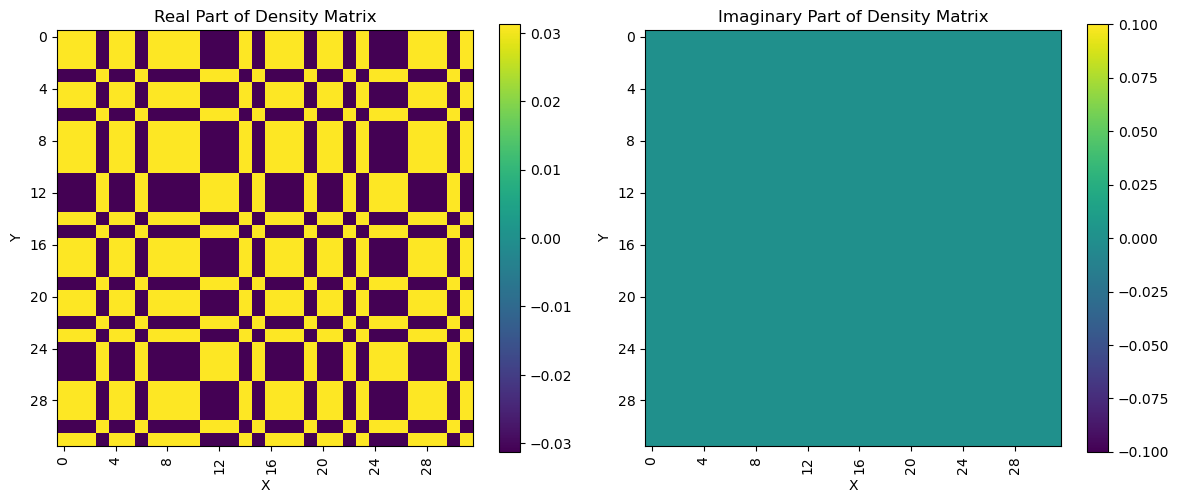

----------------------------------------
Memory Orchestrator.memo_o_2:
  Entangled Memory: {'node_id': None, 'memo_id': None}
  Quantum state stored in memory5:
  Keys:
[0, 3, 1, 4, 2]
State:
[ 0.1767767+0.j  0.1767767+0.j  0.1767767+0.j -0.1767767+0.j
  0.1767767+0.j  0.1767767+0.j -0.1767767+0.j  0.1767767+0.j
  0.1767767+0.j  0.1767767+0.j  0.1767767+0.j -0.1767767+0.j
 -0.1767767+0.j -0.1767767+0.j  0.1767767+0.j -0.1767767+0.j
  0.1767767+0.j  0.1767767+0.j  0.1767767+0.j -0.1767767+0.j
  0.1767767+0.j  0.1767767+0.j -0.1767767+0.j  0.1767767+0.j
 -0.1767767+0.j -0.1767767+0.j -0.1767767+0.j  0.1767767+0.j
  0.1767767+0.j  0.1767767+0.j -0.1767767+0.j  0.1767767+0.j]


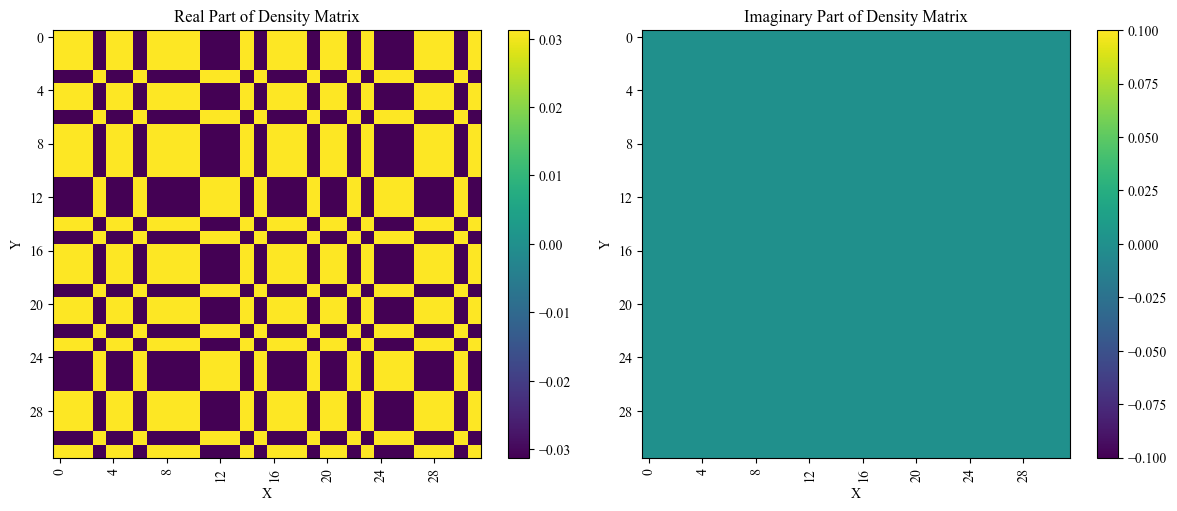

----------------------------------------
Remote Memories:
----------------------------------------
Memory client1.memo_c_1:
  Entangled Memory: {'node_id': None, 'memo_id': None}
  Quantum state stored in memory1:
  Keys:
[0, 3, 1, 4, 2]
State:
[ 0.1767767+0.j  0.1767767+0.j  0.1767767+0.j -0.1767767+0.j
  0.1767767+0.j  0.1767767+0.j -0.1767767+0.j  0.1767767+0.j
  0.1767767+0.j  0.1767767+0.j  0.1767767+0.j -0.1767767+0.j
 -0.1767767+0.j -0.1767767+0.j  0.1767767+0.j -0.1767767+0.j
  0.1767767+0.j  0.1767767+0.j  0.1767767+0.j -0.1767767+0.j
  0.1767767+0.j  0.1767767+0.j -0.1767767+0.j  0.1767767+0.j
 -0.1767767+0.j -0.1767767+0.j -0.1767767+0.j  0.1767767+0.j
  0.1767767+0.j  0.1767767+0.j -0.1767767+0.j  0.1767767+0.j]


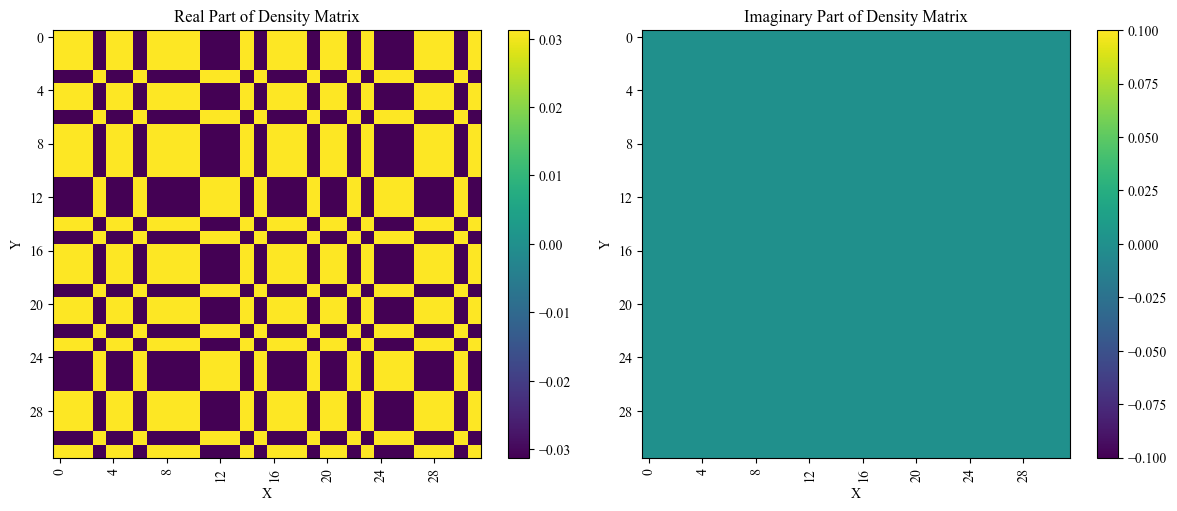

----------------------------------------
Memory client2.memo_c_1:
  Entangled Memory: {'node_id': None, 'memo_id': None}
  Quantum state stored in memory2:
  Keys:
[0, 3, 1, 4, 2]
State:
[ 0.1767767+0.j  0.1767767+0.j  0.1767767+0.j -0.1767767+0.j
  0.1767767+0.j  0.1767767+0.j -0.1767767+0.j  0.1767767+0.j
  0.1767767+0.j  0.1767767+0.j  0.1767767+0.j -0.1767767+0.j
 -0.1767767+0.j -0.1767767+0.j  0.1767767+0.j -0.1767767+0.j
  0.1767767+0.j  0.1767767+0.j  0.1767767+0.j -0.1767767+0.j
  0.1767767+0.j  0.1767767+0.j -0.1767767+0.j  0.1767767+0.j
 -0.1767767+0.j -0.1767767+0.j -0.1767767+0.j  0.1767767+0.j
  0.1767767+0.j  0.1767767+0.j -0.1767767+0.j  0.1767767+0.j]


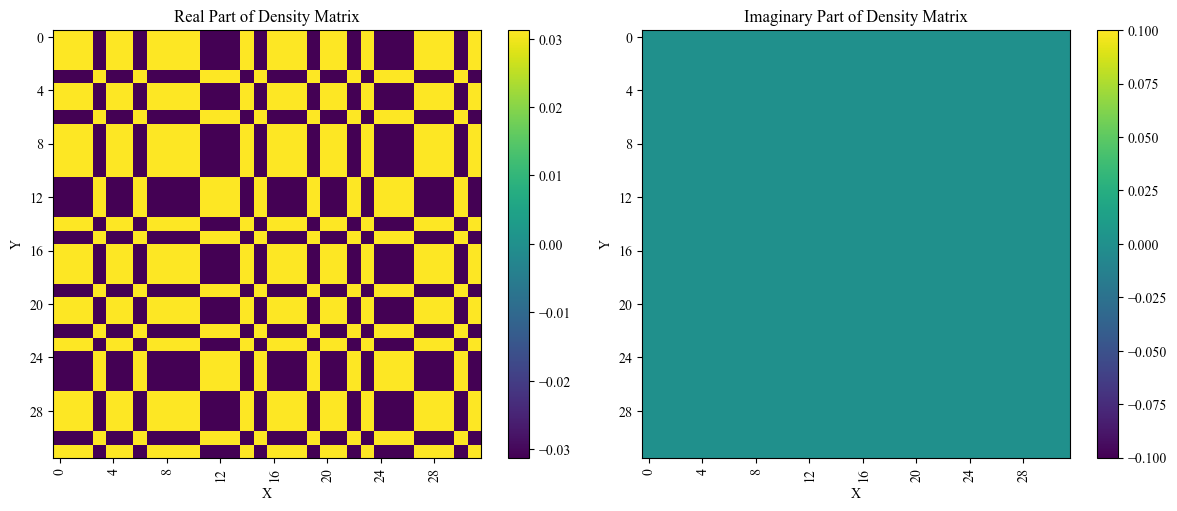

----------------------------------------
Memory client3.memo_c_1:
  Entangled Memory: {'node_id': None, 'memo_id': None}
  Quantum state stored in memory3:
  Keys:
[0, 3, 1, 4, 2]
State:
[ 0.1767767+0.j  0.1767767+0.j  0.1767767+0.j -0.1767767+0.j
  0.1767767+0.j  0.1767767+0.j -0.1767767+0.j  0.1767767+0.j
  0.1767767+0.j  0.1767767+0.j  0.1767767+0.j -0.1767767+0.j
 -0.1767767+0.j -0.1767767+0.j  0.1767767+0.j -0.1767767+0.j
  0.1767767+0.j  0.1767767+0.j  0.1767767+0.j -0.1767767+0.j
  0.1767767+0.j  0.1767767+0.j -0.1767767+0.j  0.1767767+0.j
 -0.1767767+0.j -0.1767767+0.j -0.1767767+0.j  0.1767767+0.j
  0.1767767+0.j  0.1767767+0.j -0.1767767+0.j  0.1767767+0.j]


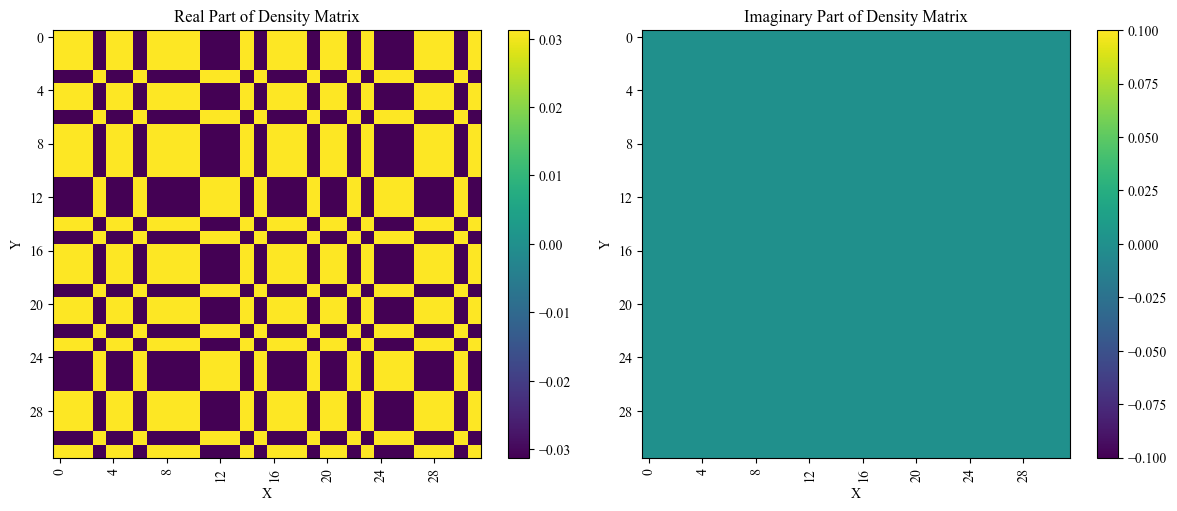

----------------------------------------


In [9]:
orch.resource_manager.create_protocol()
client1.resource_manager.create_protocol()
client2.resource_manager.create_protocol()
client3.resource_manager.create_protocol()    

tl.init()

pair_protocol(orchestrator=orch, clients=[client1, client2, client3])

# Display the state information (stored in the State Manager!)
display_state_information(tl=tl, local_memories=[memo_o_1, memo_o_2], remote_memories=[memo_c_1, memo_c_2, memo_c_3], plot_density=True)

In [10]:
print("\n ----  Orchestrator Measurement ---- \n")

client1.protocols[0].start()
client2.protocols[0].start()
client3.protocols[0].start()
orch.protocols[0].start(orch)

tl.run()


 ----  Orchestrator Measurement ---- 



Local Memories:
----------------------------------------
Memory Orchestrator.memo_o_1:
  Entangled Memory: {'node_id': None, 'memo_id': None}
  Quantum state stored in memory4:
  Keys:
[3]
State:
[1.+0.j 0.+0.j]


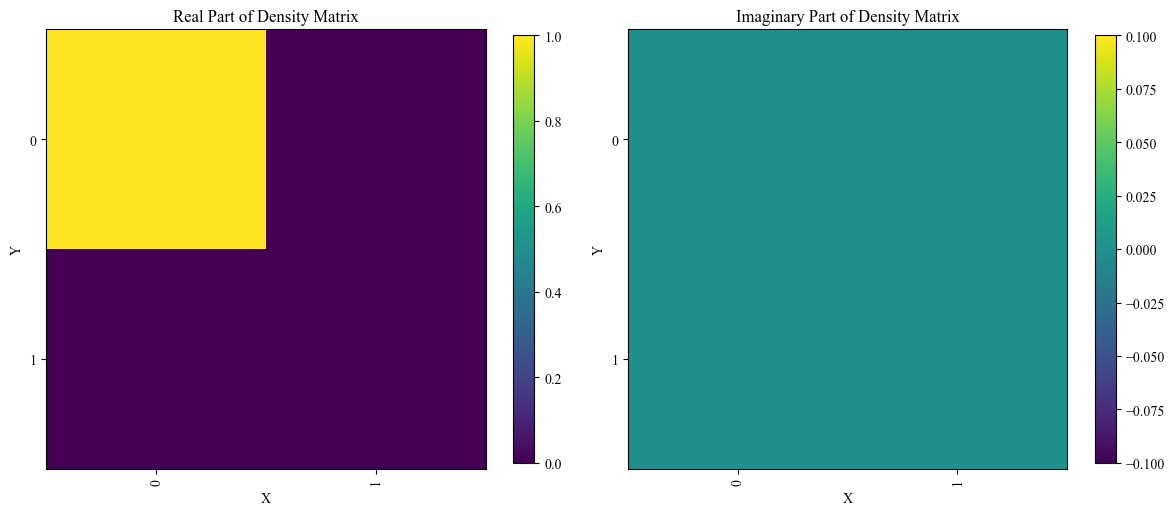

----------------------------------------
Memory Orchestrator.memo_o_2:
  Entangled Memory: {'node_id': None, 'memo_id': None}
  Quantum state stored in memory5:
  Keys:
[4]
State:
[1.+0.j 0.+0.j]


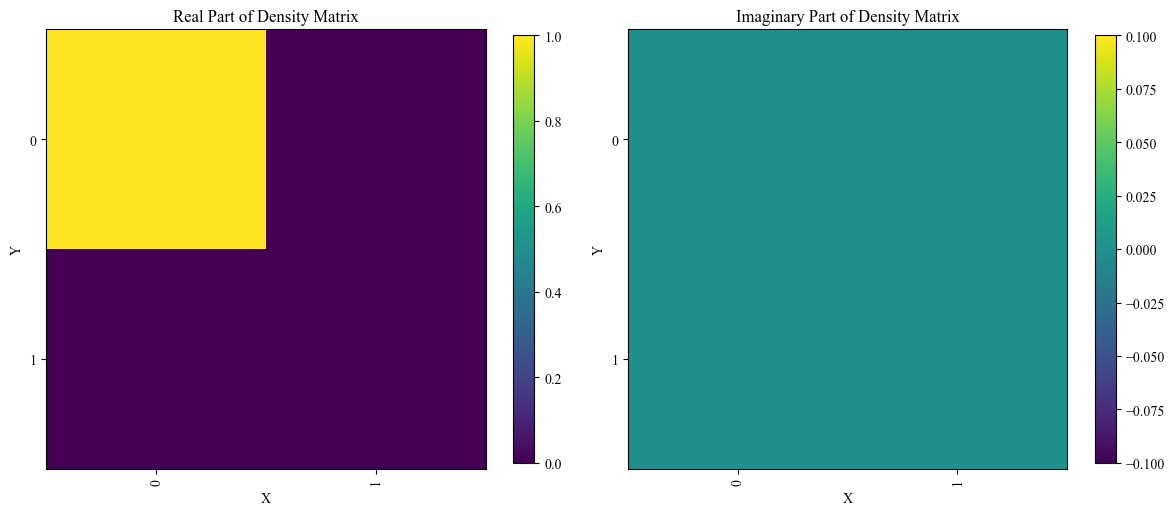

----------------------------------------
Remote Memories:
----------------------------------------
Memory client1.memo_c_1:
  Entangled Memory: {'node_id': None, 'memo_id': None}
  Quantum state stored in memory1:
  Keys:
[2, 0, 1]
State:
[ 3.36731597e-18+0.35355339j  3.36731597e-18+0.35355339j
  3.36731597e-18+0.35355339j -3.36731597e-18-0.35355339j
 -3.36731597e-18+0.35355339j  3.36731597e-18-0.35355339j
 -3.36731597e-18+0.35355339j -3.36731597e-18+0.35355339j]


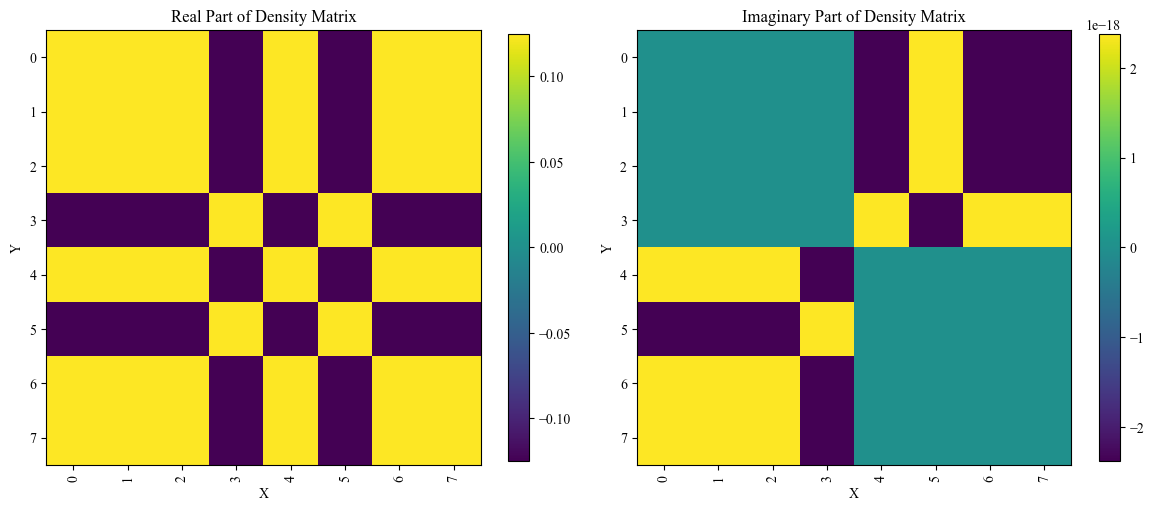

----------------------------------------
Memory client2.memo_c_1:
  Entangled Memory: {'node_id': None, 'memo_id': None}
  Quantum state stored in memory2:
  Keys:
[2, 0, 1]
State:
[ 3.36731597e-18+0.35355339j  3.36731597e-18+0.35355339j
  3.36731597e-18+0.35355339j -3.36731597e-18-0.35355339j
 -3.36731597e-18+0.35355339j  3.36731597e-18-0.35355339j
 -3.36731597e-18+0.35355339j -3.36731597e-18+0.35355339j]


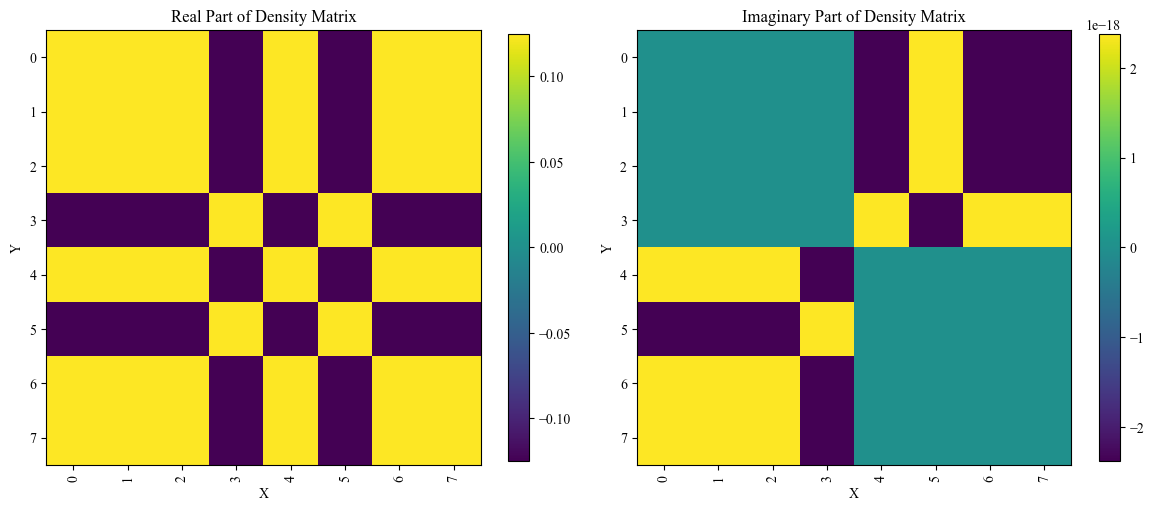

----------------------------------------
Memory client3.memo_c_1:
  Entangled Memory: {'node_id': None, 'memo_id': None}
  Quantum state stored in memory3:
  Keys:
[2, 0, 1]
State:
[ 3.36731597e-18+0.35355339j  3.36731597e-18+0.35355339j
  3.36731597e-18+0.35355339j -3.36731597e-18-0.35355339j
 -3.36731597e-18+0.35355339j  3.36731597e-18-0.35355339j
 -3.36731597e-18+0.35355339j -3.36731597e-18+0.35355339j]


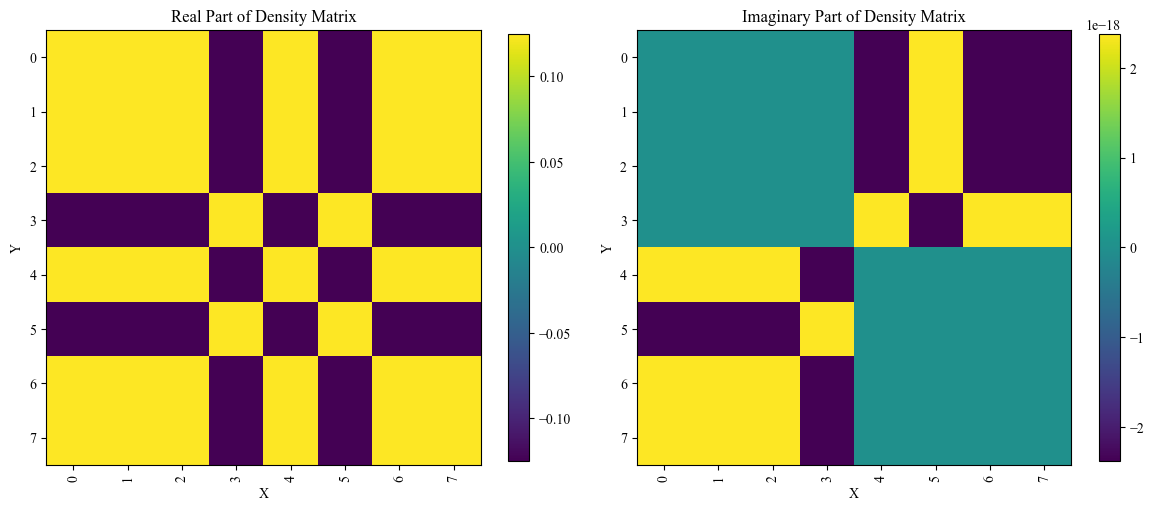

----------------------------------------


In [11]:
# Display the state information (stored in the State Manager!)
display_state_information(tl=tl, local_memories=[memo_o_1, memo_o_2], remote_memories=[memo_c_1, memo_c_2, memo_c_3])